In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import chi2

import csv
import pickle
import datetime

import autograd.numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from confint_withoutg_linear_modification import confint

np.random.seed(0)

In [2]:
n = 100
d = 1
alpha = 0.05
dist = "gaussian"
df = 3
thread_num = 8
mu = 8.0
M = 8.0
tau_max = 1e3
max_iters = 30
modification = 3

In [3]:
repeat_times = 1
coverage_rates = np.zeros(repeat_times)
entire_band_coverage_rates = np.zeros(repeat_times)

now = datetime.datetime.now()
mmddyyhhmm = ("%d_%d_%d_%d_%d" % (now.month, now.day, now.year, now.hour, now.minute))
part_of_out_fn = dist + "_n_" + str(n) + "_mod_" + str(modification) + "_uid_" + mmddyyhhmm

stuff = {}
is_save = False

In [4]:
for repeat in range(repeat_times):
# Create problem data
    if (dist == "gaussian"):
        X = np.random.randn(n)

    elif (dist == "gamma"):
        X = np.random.gamma(shape=1.0, size=n)

    elif (dist == "chisq"):
        X = np.random.chisquare(df=df, size=n)

    elif(dist == "uniform"):
        X = np.random.uniform(low=-3, high=3, size=n)

    elif(dist == "mixture"):
        n_minus1 = n / 2
        n_plus1 = n - n_minus1
        X = np.concatenate([-2 + np.random.randn(n_minus1), 2 + np.random.randn(n_plus1)])
    else:
        print("ERROR: unsupported distribution")

    X = np.sort(X)

    opt_pts_ratio = 0.5 #subsampling ratio from design points to optimize over

    conf_int = confint(n, X, alpha, opt_pts_ratio=opt_pts_ratio)
    conf_int.compute_pw_conf_ints(thread_num, M, tau_max, mu, max_iters, modification=modification)

    design_pts = X[conf_int.idxes_of_design_pts]

    conf_int.remove_nan()
    
    opt_pts = X[conf_int.idxes_of_design_pts_to_opt]

    conf_int.improve_bounds()

    stuff[dist + str(repeat) + "X"] = X
    stuff[dist + str(repeat) + "design_pts"] = design_pts
    stuff[dist + str(repeat) + "opt_pts"] = opt_pts
    stuff[dist + str(repeat) + "lo_opt_opts"] = conf_int.lo_opt_pts
    stuff[dist + str(repeat) + "hi_opt_opts"] = conf_int.hi_opt_pts
    stuff[dist + str(repeat) + "x_evaluate"] = conf_int.improved_hi_at_x
    stuff[dist + str(repeat) + "improved_lo"] = conf_int.improved_lo_opt_pts
    stuff[dist + str(repeat) + "improved_hi"] = conf_int.improved_hi_opt_pts

    ground_truth = norm.pdf(opt_pts)
#     ground_truth = np.log(1.0 / 6.0 * np.ones(len(opt_pts)))
#     ground_truth = norm.pdf(opt_pts, loc=-2) + norm.pdf(opt_pts, loc=2)
#     ground_truth = np.log(gamma.pdf(opt_pts, 1.0))
    x_evaluate_list = list(conf_int.improved_hi_at_x)
    count = 0
    w = []
    w_rel = []
    for i in range(len(opt_pts)):
        idx = x_evaluate_list.index(opt_pts[i])
        if (ground_truth[i] >= conf_int.improved_lo_opt_pts[i] 
            and ground_truth[i] <= conf_int.improved_hi_opt_pts[idx]):
            count += 1
        w.append(conf_int.improved_hi_opt_pts[i] - conf_int.improved_lo_opt_pts[i])
        w_rel.append(w[-1] / ground_truth[i])
    coverage_rate = count * 1.0 / len(opt_pts)
    coverage_rates[repeat] = coverage_rate
    if coverage_rate == 1.0:
        entire_band_coverage_rates[repeat] = 1.0
    print(repeat, coverage_rate, entire_band_coverage_rates[repeat])
    if is_save:
        with open("coverage_rates_%s.csv" % (part_of_out_fn), mode="a") as file_obj:
            csv_obj = csv.writer(file_obj, delimiter=",") # , quotechar='"', quoting=csv.QUOTE_MINIMAL
            csv_obj.writerow(["trial"+str(repeat), dist, coverage_rate, entire_band_coverage_rates[repeat]])
            file_obj.close()
    w_ave = np.mean(np.array(w))
    if is_save:
        with open("band_width_%s.csv" % (part_of_out_fn), mode="a") as file_obj:
            csv_obj = csv.writer(file_obj, delimiter=",")
            csv_obj.writerow(["trial"+str(repeat), dist, w_ave, w])
            file_obj.close()
    if is_save:
        with open("band_width_ground_truth_ratio_%s.csv" % (part_of_out_fn), mode="a") as file_obj2:
            csv_obj2 = csv.writer(file_obj2, delimiter=",")
            w_rel_ave = np.mean(np.array(w_rel))        
            csv_obj2.writerow(["trial"+str(repeat), dist, w_rel_ave, w_rel])
            file_obj2.close()

('num design points to optimize', 8)
setup workers
('worker received', 2, 'begin ccp iterations')
('worker received', 0, 'begin ccp iterations')
('worker received', 1, 'begin ccp iterations')
('worker received', 6, 'begin ccp iterations')
('worker received', 8, 'begin ccp iterations')
('worker received', 9, 'begin ccp iterations')
('worker received', 10, 'begin ccp iterations')
('worker received', 12, 'begin ccp iterations')
  quitting early ...
  quitting early ...
  quitting early ...
('minimizing over ell[', 8, ']:', 'result: objf (i.e., log prob)=', -1.9102503974625948, 'slack sum=', 8.763398373795366e-13, 'tau=', 1000.0, 'prob.status=', 'optimal', 'num of iters', 11)
('minimizing over ell[', 1, ']:', 'result: objf (i.e., log prob)=', -3.2194790423095716, 'slack sum=', 1.0921587873311145e-10, 'tau=', 1000.0, 'prob.status=', 'optimal', 'num of iters', 11)
('minimizing over ell[', 0, ']:', 'result: objf (i.e., log prob)=', -8.0, 'slack sum=', 2.5801199718737053e-10, 'tau=', 1000.0, '

In [5]:
print(coverage_rates)
print(entire_band_coverage_rates)
if is_save:
    pickle.dump(stuff, open("data_%s.pkl" % (part_of_out_fn), "wb"))

[1.]
[1.]


Text(0,0.5,'$\\log f$')

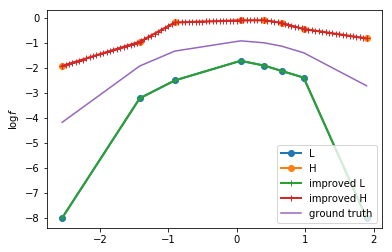

In [6]:
%matplotlib inline

plt.figure()
plt.subplot(111)
plt.plot(opt_pts, np.log(conf_int.lo_opt_pts), '-o', linewidth=2.0, label="L")
plt.plot(opt_pts, np.log(conf_int.hi_opt_pts), '-o', linewidth=2.0, label="H")
plt.plot(opt_pts, np.log(conf_int.improved_lo_opt_pts), '-+', linewidth=2.0, label="improved L")
plt.plot(conf_int.improved_hi_at_x, np.log(conf_int.improved_hi_opt_pts), '-+', linewidth=2.0, label="improved H")
plt.plot(opt_pts, np.log(norm.pdf(opt_pts)), label="ground truth")
plt.legend(loc=4)
plt.ylabel("$\log f$")